# Multi-modal embedding

**Import and initialize everything:**

In [1]:
import os
from pathlib import Path
from time import time

import numpy as np
import torch
from torch.utils.data import DataLoader
from transformers import CLIPModel, CLIPProcessor
from tqdm import tqdm

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests
from io import BytesIO


def get_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img


def show_images(list_img: [Image]):
    plt.figure(figsize=(20,10))
    for i, img in enumerate(list_img):
        plt.subplot(1, len(list_img), i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()


def plot_table_result(data, col_label, row_label):
    df = pd.DataFrame(data, index=row_label, columns=col_label)
    sns.heatmap(df, annot=True, fmt=".4f", cmap='Oranges')
    plt.show()
    
# MODEL_PATH = Path(
#     os.environ["DSDIR"] + "/HuggingFace_Models/openai/clip-vit-base-patch16"
# )
MODEL_PATH = "openai/clip-vit-base-patch16"

**Load the model and the pre-process object (tokenizer and image transformation):**

In [2]:
model = CLIPModel.from_pretrained(MODEL_PATH, ).half().to("cuda")
model.eval()
processor = CLIPProcessor.from_pretrained(MODEL_PATH)

/opt/conda/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [3]:
model

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [4]:
processor

CLIPProcessor:
- image_processor: CLIPImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

- tokenizer: CLIPTokenizerFast(name_or_path='openai/clip-vit-base-patch16', vocab_size=49408, model_max_length=77, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|startoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	49406: AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, spe

**Next we are gonna use the model to make predictions. But first we need to pre-process the data inputs**

In [5]:
text_input = ["A cute cat.", "A cute dog."]
model_inputs = processor(text=text_input, padding=True)
model_inputs

{'input_ids': [[49406, 320, 2242, 2368, 269, 49407], [49406, 320, 2242, 1929, 269, 49407]], 'attention_mask': [[1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]}

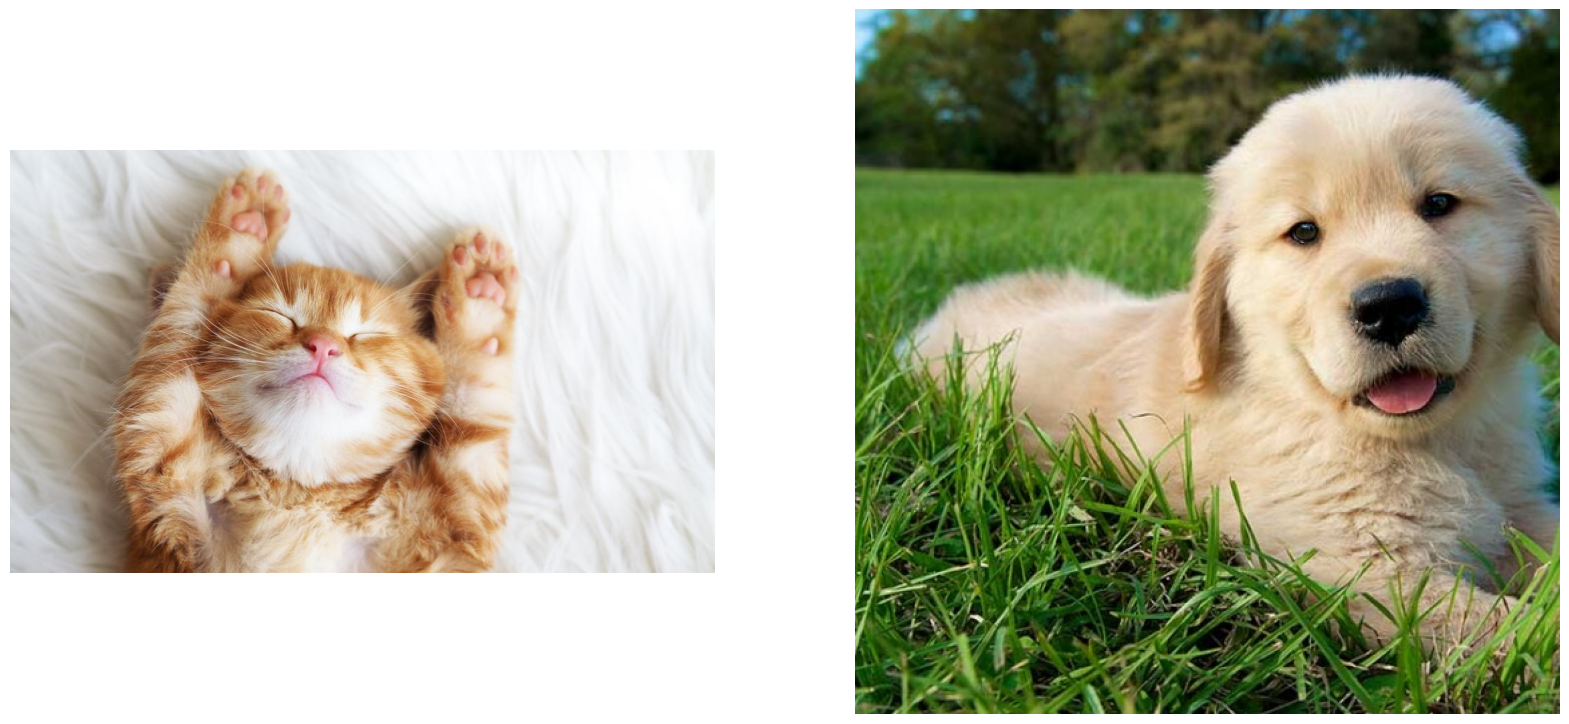

In [6]:
img_cat = get_image_from_url('https://cdn.shopify.com/s/files/1/0265/1327/7008/files/accueillir-chaton.jpg?v=1694430147')
img_dog = get_image_from_url('https://media.os.fressnapf.com/cms/2023/08/nom-de-chien_header_GettyImages-185743593.jpg?t=seoimgsqr_527')
image_dict = {"cat image": img_cat, "dog image": img_dog}
show_images(list(image_dict.values()))

In [7]:
model_inputs = processor(images=list(image_dict.values()), padding=True)
for array in model_inputs['pixel_values']:
    print(array.shape)

(3, 224, 224)
(3, 224, 224)


In [8]:
# Model inference
inputs = processor(text=text_input, images=list(image_dict.values()), return_tensors="pt", padding=True).to("cuda")
outputs = model(**inputs)
outputs.keys()

odict_keys(['logits_per_image', 'logits_per_text', 'text_embeds', 'image_embeds', 'text_model_output', 'vision_model_output'])

**CLIP return several inputs**

In [9]:
print(outputs.text_embeds.shape)
print(outputs.image_embeds.shape)

torch.Size([2, 512])
torch.Size([2, 512])


In [10]:
print(outputs.logits_per_image)
print(outputs.logits_per_text)

tensor([[27.8750, 21.5000],
        [23.1562, 29.4688]], device='cuda:0', dtype=torch.float16,
       grad_fn=<TBackward0>)
tensor([[27.8750, 23.1562],
        [21.5000, 29.4688]], device='cuda:0', dtype=torch.float16,
       grad_fn=<MulBackward0>)


**Classify the images on 2 classes "A cute cat" and "A cute dog"**

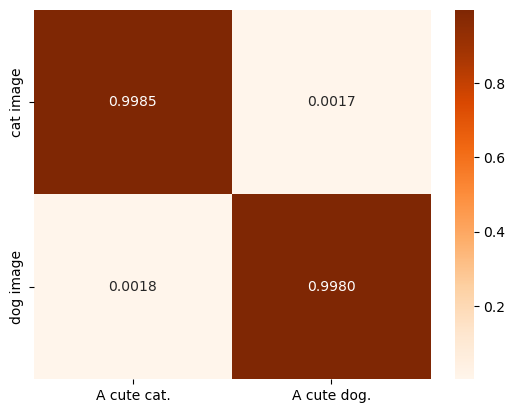

In [11]:
plot_table_result(
    outputs.logits_per_image.softmax(axis=1).detach().cpu().numpy(),
    text_input,
    list(image_dict.keys())
)

**We make a function to quickly make prediction**

In [12]:
def clip_inf(image_dict, text_list, text_class=False):
    inputs = processor(text=text_list, images=list(image_dict.values()), return_tensors="pt", padding=True).to("cuda")
    outputs = model(**inputs)

    if text_class:
        plot_table_result(
            outputs.logits_per_image.softmax(axis=1).detach().cpu().numpy(),
            text_list,
            list(image_dict.keys())
        )
    else:
        plot_table_result(
            outputs.logits_per_text.softmax(axis=1).detach().cpu().numpy(),
            list(image_dict.keys()),
            text_list,
        )

**Now we are gonna judge the physics of people (for science!)**

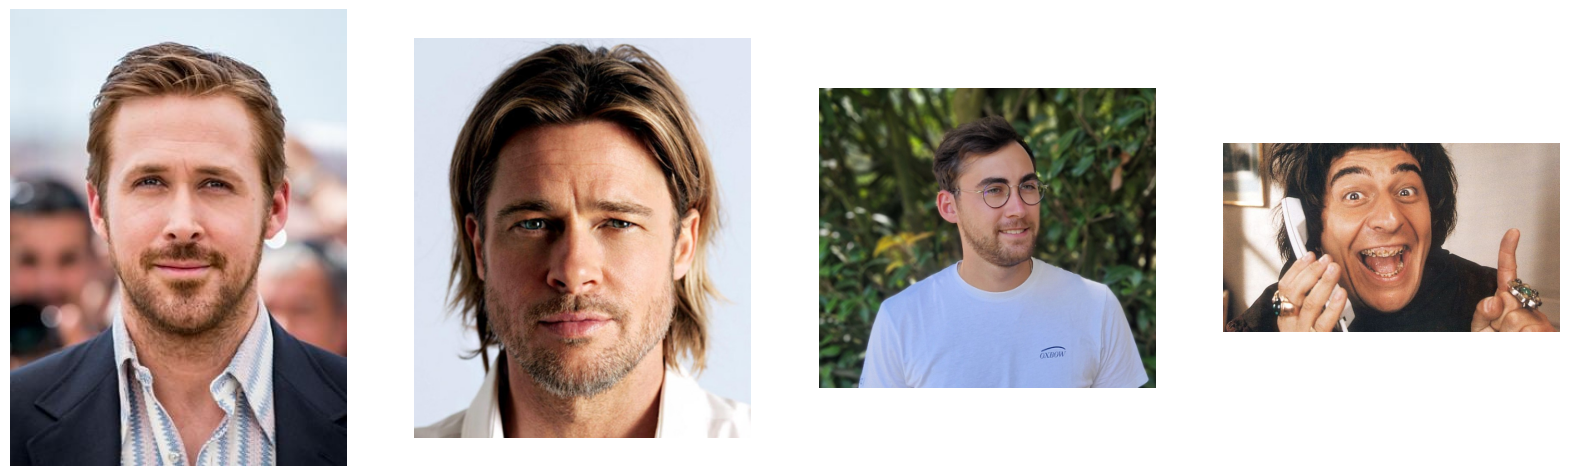

In [13]:
ryan = get_image_from_url('https://fr.web.img3.acsta.net/c_310_420/pictures/16/05/17/17/28/208580.jpg')
brad = get_image_from_url('https://images.mubicdn.net/images/cast_member/2552/cache-207-1524922850/image-w856.jpg?size=800x')
leo = get_image_from_url('https://www.ins2i.cnrs.fr/sites/institut_ins2i/files/styles/person/public/image/l%C3%A9o%20h.jpg?h=437e56df&itok=wYMWVl9o')
jacquouille = get_image_from_url('https://usbeketrica.com/media/93184/download/jacqouilles.jpg?v=1&inline=1')
image_dict = {"Ryan": ryan, "Brad": brad, "Leo": leo, "Jacquouille": jacquouille}
show_images(list(image_dict.values()))

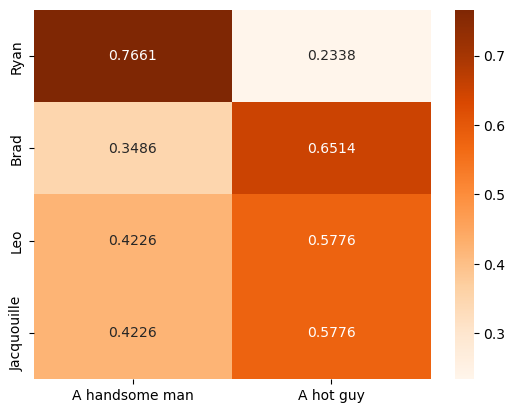

In [14]:
clip_inf(image_dict, ["A handsome man", "A hot guy"], text_class=True)

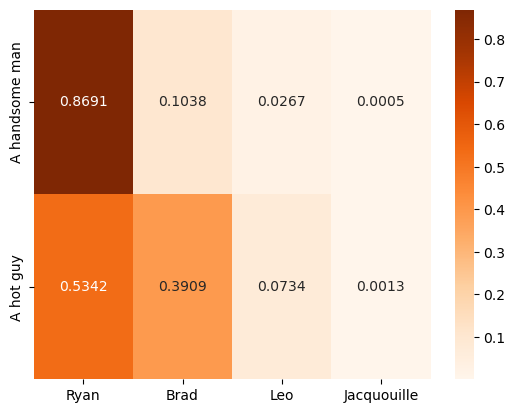

In [15]:
clip_inf(image_dict, ["A handsome man", "A hot guy"])

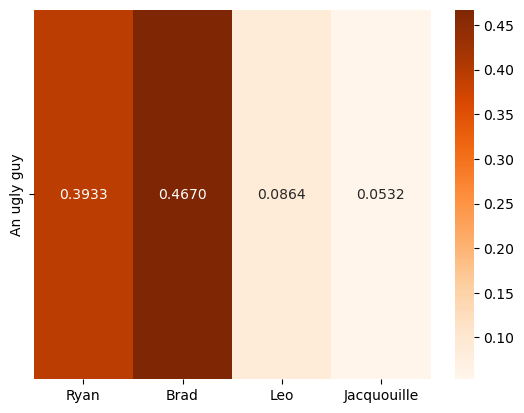

In [16]:
clip_inf(image_dict, ["An ugly guy"])

**Now we are gonna play with the embedding of CLIP**

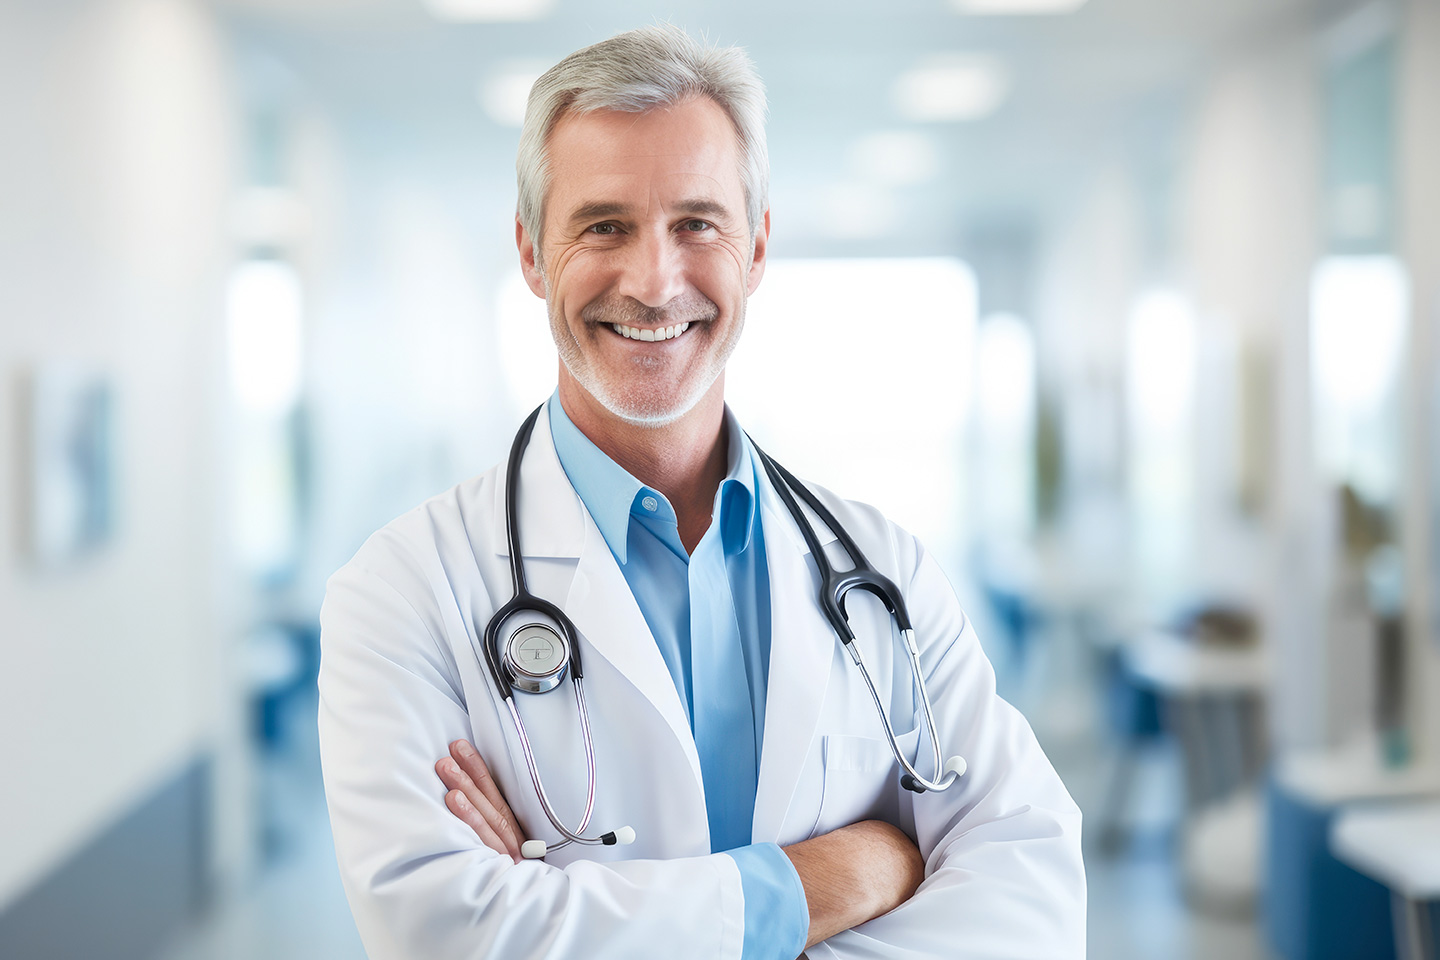

In [17]:
img_doctor = get_image_from_url('https://www.thebaide-conseils.fr/wp-content/uploads/2023/06/reforme-des-retraitres-medecin.jpg')
image_dict = {"Man doctor": img_doctor}
img_doctor

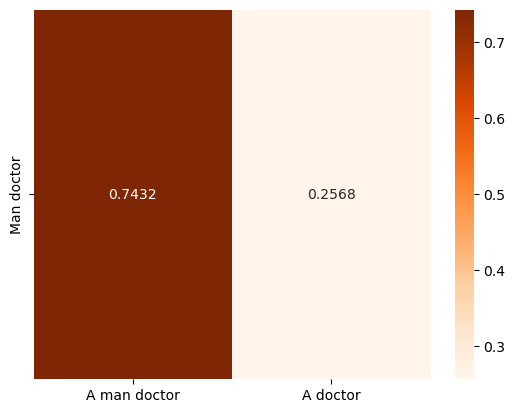

In [18]:
clip_inf(image_dict, ["A man doctor", "A doctor"], text_class=True)

In [19]:
text_inputs = ["Man", "Woman", "A woman doctor", "A doctor", "A nurse", "A car with black wheel", "The Eiffel tower"]
inputs = processor(
    text=text_inputs,
    images=list(image_dict.values()),
    return_tensors="pt",
    padding=True
).to("cuda")
outputs = model(**inputs)
img_m_doc_embed = outputs.image_embeds
text_embed = outputs.text_embeds
man_embed, woman_embed, w_doc_embed, doc_embed, nurse_embed, car_embed, et_embed = outputs.text_embeds

In [24]:
def compare_embed(embeds1, embeds2, labels1=None, labels2=None):
    result = torch.matmul(embeds1, embeds2.t()).softmax(axis=1)
    plot_table_result(result.detach().cpu().numpy(), labels2, labels1)
    return result

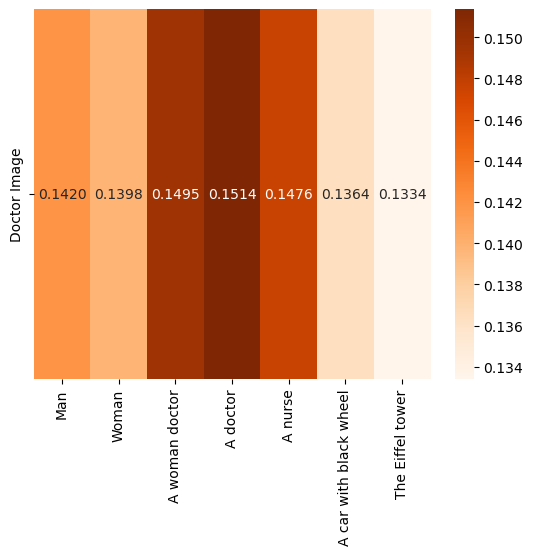

tensor([[0.1420, 0.1398, 0.1495, 0.1514, 0.1476, 0.1364, 0.1334]],
       device='cuda:0', dtype=torch.float16, grad_fn=<SoftmaxBackward0>)

In [25]:
compare_embed(img_m_doc_embed, text_embed, ["Doctor Image"], text_inputs)

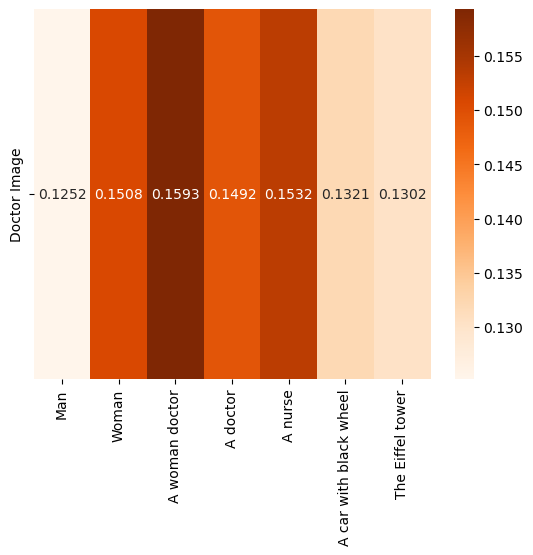

tensor([[0.1252, 0.1508, 0.1593, 0.1492, 0.1532, 0.1321, 0.1302]],
       device='cuda:0', dtype=torch.float16, grad_fn=<SoftmaxBackward0>)

In [26]:
woman_doc = img_m_doc_embed - man_embed + woman_embed
compare_embed(woman_doc, text_embed, ["Doctor Image"], text_inputs)